# TD5 - Flower Classification

Fabiano Junior Maia Manschein

IMLEX

References:
- https://www.tensorflow.org/tutorials/load_data/images

# Imports

In [2]:
from keras.datasets import mnist     
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import gradient_descent_v2
from sklearn.model_selection import KFold
import numpy as np
import keras_tuner
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import os
import PIL.Image
import tensorflow as tf
import shutil
import pathlib

import matplotlib.pyplot as plt  # package for visualisation
%matplotlib inline  

# Data

The dataset contains 800 RGB images of 10 different categories of flowers, with 600 of these images for the training set, and 200 for the validation set. We'll consider the flower categories as the classes, and the training and validation sets have 60 and 20 images per class, respectively.

In [3]:
base_path = "data/Flowers/"
data_dir = pathlib.Path(base_path)
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print(f"Number of images: {image_count}")

Number of images: 800


## Training, validation and test datasets

Since the images are already separated into training and test sets, all we have to do is load them. We'll use a 80/20 split for training/validation.

Here, we load the data using two different methods: `image_dataset_from_directory()` and `ImageDataGenerator.flow_from_directory()`. I did this because I wanted to experiment with both methods of loading the data and, as far as I know, data augmentation is not possible with `image_dataset_from_directory()` and `flow_from_directory()` gives more flexibility.

It will also be interesting to evaluate the model trained on raw data versus trained on augmented data.

In [4]:
# Loader parameters
batch_size = 32
img_height = 128
img_width = 128
train_dir = pathlib.Path(base_path + "Train/")
test_dir = pathlib.Path(base_path + "Test/") 

print("Training and validation")
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  subset="both",
  validation_split=0.2,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

print("Test")
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

# print("ImageDataGenerator")
# Load images using the ImageDataGenerator
# datagen = ImageDataGenerator(rescale=1./255)

# train_it = datagen.flow_from_directory(train_dir, class_mode='categorical', target_size=(img_height, img_width), subset="training", s)
# val_it = datagen.flow_from_directory(train_dir, class_mode='categorical', target_size=(img_height, img_width), subset="validation")
# test_it = datagen.flow_from_directory(test_dir, class_mode='categorical', target_size=(img_height, img_width))

Training and validation
Found 600 files belonging to 10 classes.
Using 480 files for training.
Using 120 files for validation.
Test
Found 200 files belonging to 10 classes.


Let's check the class names:

In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)
# class_indices = train_it.class_indices
print(num_classes, class_names)

10 ['Fleurs0', 'Fleurs1', 'Fleurs2', 'Fleurs3', 'Fleurs4', 'Fleurs5', 'Fleurs6', 'Fleurs7', 'Fleurs8', 'Fleurs9']


## Visualize the data

Here are the first 9 images from the training dataset.

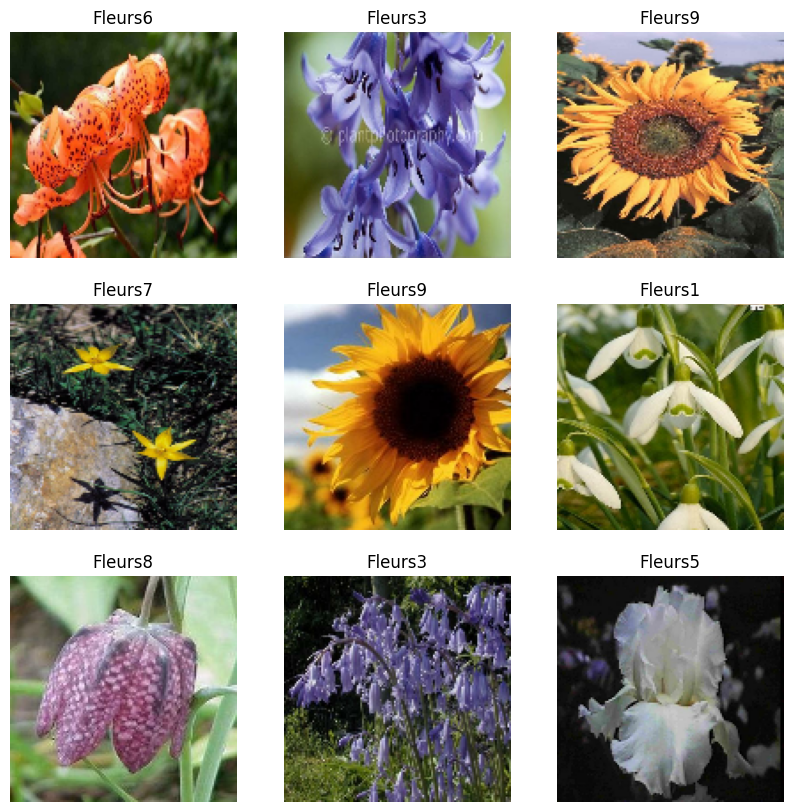

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

And for the augmented data:

In [7]:
# # get the first 9 images from the generator
# images, labels = train_it.next()
# images = images[:9]
# labels = labels[:9]

# # plot the images
# fig, axes = plt.subplots(3, 3, figsize=(8, 8))
# axes = axes.ravel()

# for i in range(9):
#     axes[i].imshow(images[i])
#     label_index = np.where(labels[i] == 1)[0][0]
#     axes[i].set_title(class_names[label_index])
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()

Retrieve batches of images:

In [8]:
for image_batch, labels_batch in train_ds:
  print(f"Image shape = {image_batch.shape}, labels batch shape = {labels_batch.shape}")
  break

# Augmented data
# batchX, batchY = train_it.next()
# print(f'Augmented data batch shape = {batchX.shape}')

Image shape = (32, 128, 128, 3), labels batch shape = (32,)


The image_batch is a tensor of the shape `(32, 128, 128, 3)`. This is a batch of 32 images of shape `128x128x3` (the last dimension refers to color channels RGB). The `labels_batch` is a tensor of the shape `(32,)`, these are the corresponding labels to the 32 images.

## Standardize the data

The RGB channel values are in the `[0, 255]` range. Here, we will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

*Note*: `ImageDataGenerator` has a parameter for rescaling, which was used when loading the data.

In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

We can either apply this layer to the dataset, or include it as part of the model definition. Here, we apply it to the dataset:

In [10]:
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(f"Min/max pixel values: {np.min(first_image)}, {np.max(first_image)}")

# For the augmented data:
# print(f'Augmented data pixel values: min={batchX.min()}, max={batchX.max()}')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Min/max pixel values: 0.0, 1.0


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods we should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training the model. If the dataset is too large to fit into memory, we can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Training a model from scratch

In this section, we'll build our own architecture step-by-step, and train it. Let's start with a very simple model.

In [12]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

Let's train it for a small number of `epochs` to check its performance. This will be our base reference for improving it.

In [13]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
15/15 [==============================] - 3s 146ms/step - loss: 7.2516 - accuracy: 0.2062 - val_loss: 3.3034 - val_accuracy: 0.2417
Epoch 2/5
15/15 [==============================] - 2s 128ms/step - loss: 1.8679 - accuracy: 0.4625 - val_loss: 1.6932 - val_accuracy: 0.4333
Epoch 3/5
15/15 [==============================] - 2s 117ms/step - loss: 0.9071 - accuracy: 0.7500 - val_loss: 1.2134 - val_accuracy: 0.6083
Epoch 4/5
15/15 [==============================] - 2s 103ms/step - loss: 0.4396 - accuracy: 0.9104 - val_loss: 1.0662 - val_accuracy: 0.6583
Epoch 5/5
15/15 [==============================] - 2s 107ms/step - loss: 0.2282 - accuracy: 0.9521 - val_loss: 0.8493 - val_accuracy: 0.7250


In [14]:
score = model.evaluate(test_ds)

base_acc = score[1]
print(f'Test accuracy: {score[1]:.3f}')

7/7 [==============================] - 0s 25ms/step - loss: 176.8678 - accuracy: 0.5850
Test accuracy: 0.585


We can easily notice overfitting past the third `epoch`. This already indicates we might need dropout and data augmentation layers to counter overfitting and improve validation accuracy. Before that, let's make the model a bit more complex.

## Improvement 1: padding, number of layers, progressive increase of neurons

Currently, the model has a single convolution layers, and a single max pooling layer. As such, the output is reduced to `63x63` from its original input `128x128`, meaning that the feature maps don't go much into the finer details of the images. This can be seen below, with the summary of the model.

Also, as we're using only 32 neurons in the convolution layer, we only have 32 feature maps. You typically want more features than categories. Let's first try increasing the number of feature maps a bit.

We also want to keep the output shape the same as the input for convolution layers. We'll adjust the padding to get this result.

In [18]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

score = model.evaluate(test_ds)
print(f'Test accuracy: {score[1]:.3f} \nImprovement (%): {score[1] - base_acc:.3f}')

Epoch 1/5
15/15 [==============================] - 14s 846ms/step - loss: 2.2477 - accuracy: 0.2146 - val_loss: 1.9965 - val_accuracy: 0.2417
Epoch 2/5
15/15 [==============================] - 12s 810ms/step - loss: 1.2765 - accuracy: 0.5417 - val_loss: 1.2384 - val_accuracy: 0.6000
Epoch 3/5
15/15 [==============================] - 12s 830ms/step - loss: 0.7073 - accuracy: 0.7604 - val_loss: 1.0652 - val_accuracy: 0.6833
Epoch 4/5
15/15 [==============================] - 13s 892ms/step - loss: 0.4529 - accuracy: 0.8208 - val_loss: 1.6073 - val_accuracy: 0.5917
Epoch 5/5
7/7 [==============================] - 1s 96ms/step - loss: 244.9758 - accuracy: 0.5550


ValueError: Invalid format specifier

After a certain point, max pooling no longe can reduce the number of parameters to compensate the addition of the convolution layer. Also, it seems like the model requires more `epochs` to reach a stable training accuracy, i.e. it's not overfitting now, but likely underfitting. Not only that, but it seems like we'll need to tune either the stride or the padding (or both) to make sure the convolutions don't change the input size.

**Conclusion**: just adding more convolutions and max pooling layers until we can't anymore is not a good solution and slows down training time considerably without any significant improvement in accuracy. We need to think a bit more about how to handle the architecture:

- Make sure the convolutional layers don't change the input shape. We'll do that by using `padding=same` in every layer. That way, we'll be sure to use all pixels from the inputs.
- Reduce number of layers so that the final output shape is `(16, 16)`. This idea comes from looking at the dataset: we can distinguish flowers by shape and color, which are mostly major characteristics in the images, except for flowers that are very similar. In these exceptions, we need to look into finer details, hence looking at a `8x8` area makes sense. Also, in some of the images, the flowers compose a very small percentage of the pixels.
- Possibly use a bigger kernel size with `stride=1` in the first convolution to focus more on color and shape of the flowers.
- Following up the idea of the bigger features (color, shape) vs small details, we'll also increase the number of feature maps (i.e., neurons) as we go deeper into the network. This idea came from looking at popular CNNs VGG-19 and RES-net.

## Architecture rework #1: padding, stride, and convolutional layers

In [16]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(128, 5, activation='relu', input_shape=(img_height, img_width, 3), padding="same", strides=1),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', input_shape=(img_height, img_width, 3), padding="same"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', input_shape=(img_height, img_width, 3), padding="same"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', input_shape=(img_height, img_width, 3), padding="same"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

score = model.evaluate(test_ds)
print(f'Test accuracy: {score[1]:.3f}')

Epoch 1/5
15/15 [==============================] - 16s 1s/step - loss: 2.2987 - accuracy: 0.1417 - val_loss: 2.1353 - val_accuracy: 0.2167
Epoch 2/5
15/15 [==============================] - 15s 1s/step - loss: 1.9601 - accuracy: 0.2313 - val_loss: 1.9211 - val_accuracy: 0.2250
Epoch 3/5
15/15 [==============================] - 15s 979ms/step - loss: 1.6652 - accuracy: 0.3417 - val_loss: 1.6952 - val_accuracy: 0.3500
Epoch 4/5
15/15 [==============================] - 15s 1s/step - loss: 1.3935 - accuracy: 0.4688 - val_loss: 1.4766 - val_accuracy: 0.4667
Epoch 5/5
7/7 [==============================] - 1s 177ms/step - loss: 322.1128 - accuracy: 0.3450
Test accuracy: 0.345


Test accuracy reduced by nearly half, dropping to around `0.25`. We'll change back to a `3x3` kernel with no stride, and try adjusting the number of neurons to increase as the network deepens, starting with 32.

**Conclusions**: increases in kernel size vastly deteriorated test accuracy. Same for adding stride. Removing the last pair of convolution + max pooling layer didn't have any noticeable effect on the test accuracy. Increasing number of neurons as the network deepens didn't affect train accuracy, but did make training faster.



## Batchnorms and Dropout

Let's try improving accuracy by applying batch normalization and dropout to our model. After some research, I found this paper that recommends to always add the Dropout layer after the BatchNorm to avoid variance shift. Let's try and apply that. 

Source: [Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)

# Data augmentation

https://www.tensorflow.org/tutorials/images/classification#data_augmentation

https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5

# Tuning model hyperparameters

https://keras.io/guides/keras_tuner/getting_started/